In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from collections import Counter
import string
from konlpy.tag import Okt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train = pd.read_csv("../data/train.csv")
dev = pd.read_csv("../data/dev.csv")
test = pd.read_csv("../data/test.csv")

In [4]:
# 1. 데이터 크기 및 결측치 확인
print("✅ [1] 데이터 개수")
print(f"Train samples: {len(train)}")
print(f"Dev samples: {len(dev)}")
print(f"Test samples: {len(test)}\n")

✅ [1] 데이터 개수
Train samples: 12457
Dev samples: 499
Test samples: 499



In [5]:
print("✅ [2] 결측치 확인")
print(train.isnull().sum())
print(dev.isnull().sum())
print(test.isnull().sum())

✅ [2] 결측치 확인
fname       0
dialogue    0
summary     0
topic       0
dtype: int64
fname       0
dialogue    0
summary     0
topic       0
dtype: int64
fname       0
dialogue    0
dtype: int64


In [10]:
# 3. dialogue/summary 길이 통계
train['dialogue_len'] = train['dialogue'].apply(len)
train['summary_len'] = train['summary'].apply(len)

dev['dialogue_len'] = dev['dialogue'].apply(len)
dev['summary_len'] = dev['summary'].apply(len)

test['dialogue_len'] = test['dialogue'].apply(len)  # summary 없음


print("✅ [3] dialogue 길이 통계")
print("Train:", train['dialogue_len'].describe())
print("Dev  :", dev['dialogue_len'].describe())
print("Test :", test['dialogue_len'].describe())

print("\n✅ [3] summary 길이 통계")
print("Train:", train['summary_len'].describe())
print("Dev  :", dev['summary_len'].describe())
print("Test: ❌ 없음 (summary 미제공)")

✅ [3] dialogue 길이 통계
Train: count    12457.000000
mean       406.083487
std        197.566083
min         84.000000
25%        280.000000
50%        369.000000
75%        500.000000
max       2165.000000
Name: dialogue_len, dtype: float64
Dev  : count     499.000000
mean      400.054108
std       186.163807
min       114.000000
25%       273.000000
50%       367.000000
75%       487.000000
max      1269.000000
Name: dialogue_len, dtype: float64
Test : count     499.000000
mean      422.066132
std       218.245122
min       111.000000
25%       280.000000
50%       386.000000
75%       528.500000
max      2275.000000
Name: dialogue_len, dtype: float64

✅ [3] summary 길이 통계
Train: count    12457.000000
mean        85.789436
std         33.811948
min         13.000000
25%         61.000000
50%         80.000000
75%        104.000000
max        376.000000
Name: summary_len, dtype: float64
Dev  : count    499.000000
mean      81.206413
std       32.577548
min       29.000000
25%       58.000


✅ [4] 길이 분포 시각화


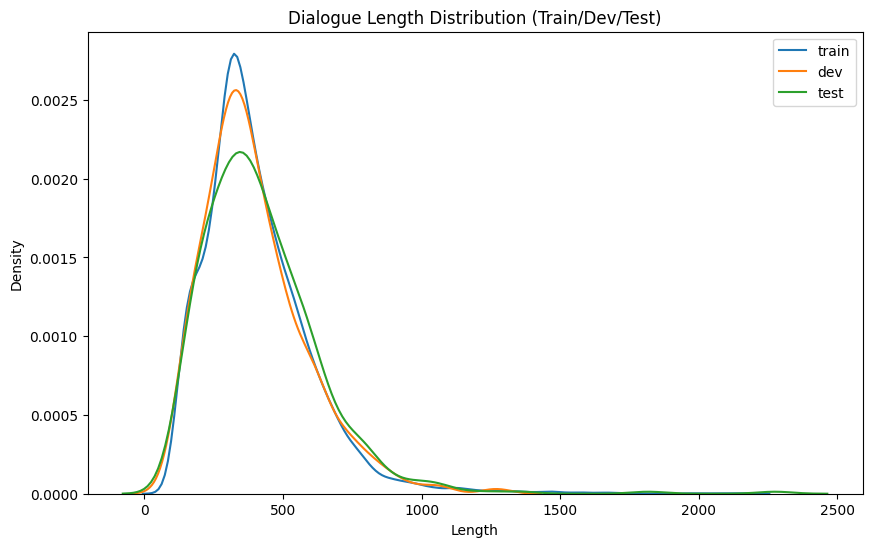

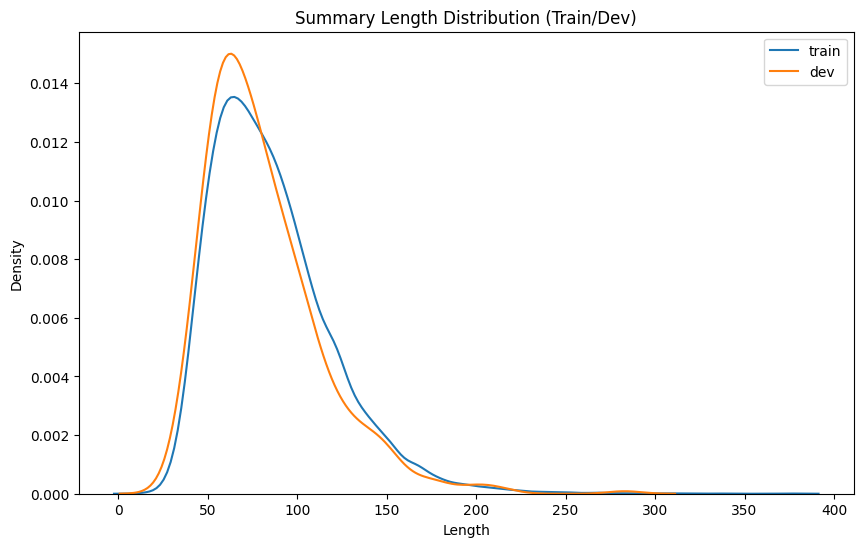

In [11]:
# 4. 길이 분포 시각화 -> dialogue_len, summary_len에 대해 히스토그램 + 커널 밀도 추정(KDE) 시각화
print("\n✅ [4] 길이 분포 시각화")

plt.figure(figsize=(10, 6))
sns.kdeplot(train["dialogue_len"], label='train')
sns.kdeplot(dev["dialogue_len"], label='dev')
sns.kdeplot(test["dialogue_len"], label='test')
plt.title("Dialogue Length Distribution (Train/Dev/Test)")
plt.legend()
plt.xlabel("Length")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(train["summary_len"], label='train')
sns.kdeplot(dev["summary_len"], label='dev')
plt.title("Summary Length Distribution (Train/Dev)")
plt.legend()
plt.xlabel("Length")
plt.ylabel("Density")
plt.show()

**5. 등장 화자 수 분석**

🔍 **분석 목적 정리**  
왜 필요한가?  
→ 대화의 복잡도 파악 및 tokenizer special token 수 결정에 중요함  
→ 화자가 많을수록 요약 난이도 ↑  
→ 화자 수 분포가 train/dev/test 간 유사한지도 중요  

분석 가능한가?  
→ ✅ dialogue만 있으면 가능 (test 포함)

✅ [5] 화자 수 분포 (value_counts)

Train:
num_speakers
2    12335
3      107
4       10
5        3
6        1
7        1
Name: count, dtype: int64

Dev:
num_speakers
2    494
3      4
4      1
Name: count, dtype: int64

Test:
num_speakers
2    495
3      4
Name: count, dtype: int64


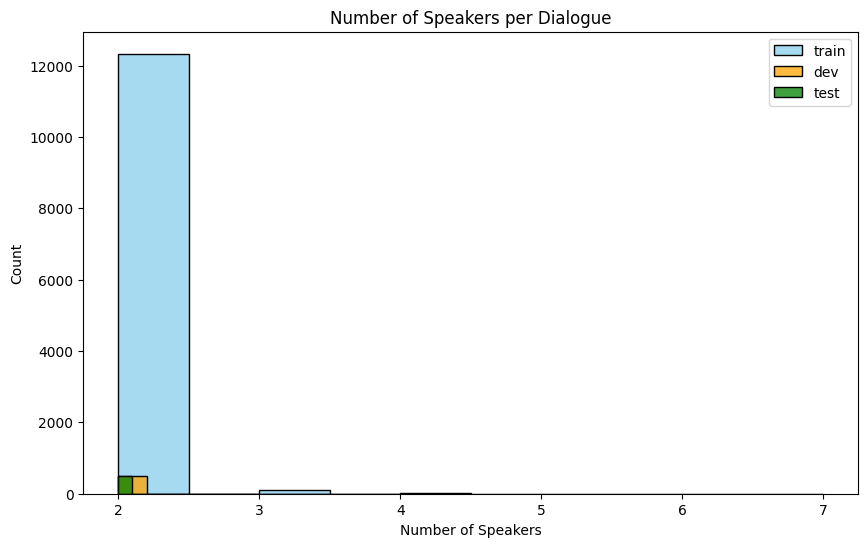

In [14]:
# 화자 수 추출 함수
def count_speakers(text):
    speakers = set(re.findall(r"#Person\d+#", text))
    return len(speakers)

# 각 데이터셋에 화자 수 컬럼 추가
train["num_speakers"] = train["dialogue"].apply(count_speakers)
dev["num_speakers"] = dev["dialogue"].apply(count_speakers)
test["num_speakers"] = test["dialogue"].apply(count_speakers)

# 화자 수 분포 출력
print("✅ [5] 화자 수 분포 (value_counts)")
print("\nTrain:")
print(train["num_speakers"].value_counts().sort_index())
print("\nDev:")
print(dev["num_speakers"].value_counts().sort_index())
print("\nTest:")
print(test["num_speakers"].value_counts().sort_index())

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train["num_speakers"], bins=10, label='train', kde=False, color='skyblue', stat="count")
sns.histplot(dev["num_speakers"], bins=10, label='dev', kde=False, color='orange', stat="count")
sns.histplot(test["num_speakers"], bins=10, label='test', kde=False, color='green', stat="count")
plt.title("Number of Speakers per Dialogue")
plt.xlabel("Number of Speakers")
plt.ylabel("Count")
plt.legend()
plt.show()

**6. 마스킹된 개인정보 토큰 분석**

🔍 **분석 목적**
- 마스킹된 토큰 종류 및 빈도 파악
- 모델 학습 시 special_tokens 설정을 위한 근거 데이터로 활용
- 데이터셋 간(Train/Dev/Test) 토큰 분포 비교 → 편향 여부 진단

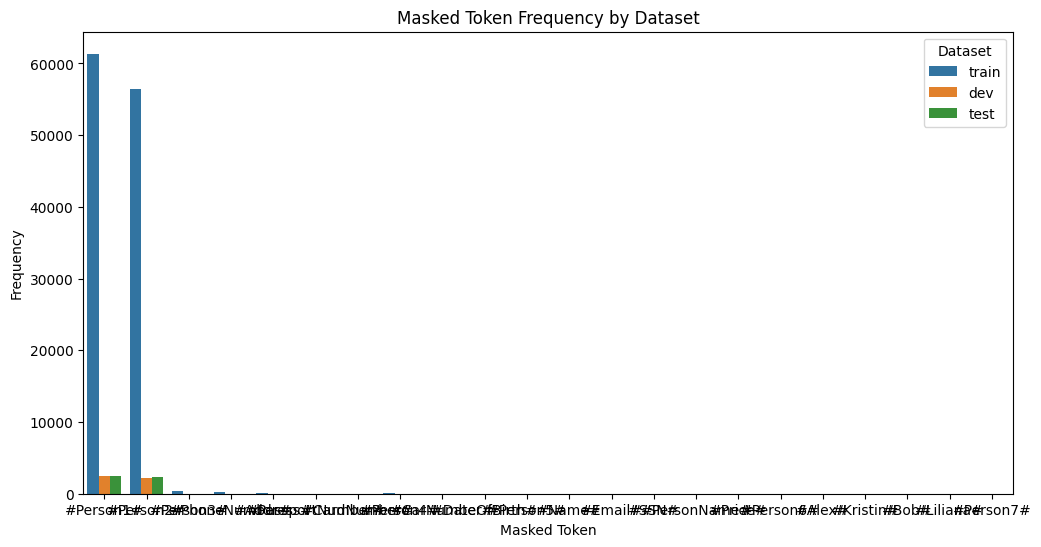

In [3]:
# 마스킹된 토큰 추출 함수
def extract_masked_tokens(text):
    return re.findall(r"#\w+#", text) # #로 감싸진 단어를 정규표현식으로 추출

# 각 대화에 있는 마스킹된 토큰을 하나의 리스트로 평탄화
train_tokens = train["dialogue"].apply(extract_masked_tokens).explode().dropna()
dev_tokens = dev["dialogue"].apply(extract_masked_tokens).explode().dropna()
test_tokens = test["dialogue"].apply(extract_masked_tokens).explode().dropna()

# 빈도 계산 (토큰별 등장 횟수)
train_counts = Counter(train_tokens)
dev_counts = Counter(dev_tokens)
test_counts = Counter(test_tokens)

# 시각화용 데이터프레임 생성
df_token = pd.DataFrame([
    {"token": token, "count": count, "split": "train"} for token, count in train_counts.items()
] + [
    {"token": token, "count": count, "split": "dev"} for token, count in dev_counts.items()
] + [
    {"token": token, "count": count, "split": "test"} for token, count in test_counts.items()
])

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df_token, x="token", y="count", hue="split")
plt.title("Masked Token Frequency by Dataset")
plt.xlabel("Masked Token")
plt.ylabel("Frequency")
plt.legend(title="Dataset")
plt.show()

🧠 **해석 팁**
- train_count이 압도적으로 높은 경우: 학습 시 모델이 해당 토큰에 과적합할 가능성
- test_count만 높은 경우: unseen token → tokenizer의 unknown 처리 여부 확인 필요
- #PersonX#처럼 연속된 번호 → 개수만큼 special_token 등록할지 범용 처리할지 결정 필요

In [6]:
# 요약 테이블 생성 : 세 데이터셋의 토큰을 합집합으로 정리
all_tokens = set(train_counts) | set(dev_counts) | set(test_counts)
summary_table = []

for token in sorted(all_tokens):
    summary_table.append({
        "token": token,
        "train_count": train_counts.get(token, 0),
        "dev_count": dev_counts.get(token, 0),
        "test_count": test_counts.get(token, 0),
        "total": train_counts.get(token, 0) + dev_counts.get(token, 0) + test_counts.get(token, 0)
    })

token_df = pd.DataFrame(summary_table).sort_values(by="total", ascending=False).reset_index(drop=True)
print(token_df)

               token  train_count  dev_count  test_count  total
0          #Person1#        61361       2439        2518  66318
1          #Person2#        56447       2244        2306  60997
2          #Person3#          379          6          15    400
3      #PhoneNumber#          228          5           5    238
4          #Address#           89          2           1     92
5          #Person4#           35          1           0     36
6      #DateOfBirth#           24          3           0     27
7            #Email#           14          0           0     14
8       #CardNumber#           14          0           0     14
9   #PassportNumber#            7          0           1      8
10       #CarNumber#            8          0           0      8
11         #Person6#            6          0           0      6
12         #Person5#            5          0           0      5
13            #Name#            4          0           0      4
14             #Bob#            3       

**7. 노이즈 탐지**

(1) 노이즈 패턴 제시 방식

In [7]:
# 대화 컬럼 복사
train["dialogue_clean"] = train["dialogue"].astype(str)
dev["dialogue_clean"] = dev["dialogue"].astype(str)
test["dialogue_clean"] = test["dialogue"].astype(str)

# 확인할 노이즈 패턴 목록
patterns = {
    "\\\\n": r"\\n",           # \n 문자열이 이스케이프된 형태
    "<br>": r"<br>",           # HTML 줄바꿈
    "ㅋㅋ": r"ㅋㅋ+",           # 반복되는 감정 표현
    "ㅎㅎ": r"ㅎㅎ+",
    "??": r"\?\?",             # 중복된 물음표
    "..": r"\.\.",             # 중복된 마침표
    "--": r"\-\-"              # 반복된 대시
}

# 결과 저장
results = []

for name, pattern in patterns.items():
    results.append({
        "pattern": name,
        "train_count": train["dialogue_clean"].str.contains(pattern).sum(),
        "dev_count": dev["dialogue_clean"].str.contains(pattern).sum(),
        "test_count": test["dialogue_clean"].str.contains(pattern).sum()
    })

# 결과 출력
noise_df = pd.DataFrame(results).sort_values(by="train_count", ascending=False).reset_index(drop=True)
print(noise_df)

  pattern  train_count  dev_count  test_count
0      ..         1260         57          57
1      --           10          0           0
2     \\n            1          0           0
3    <br>            1          0           0
4      ㅎㅎ            1          0           0
5      ??            1          0           0
6      ㅋㅋ            0          0           0


In [10]:
sample = train[train['dialogue'].str.contains("ㅎㅎ")]["dialogue"].head(5)
for d in sample:
    print(d)

#Person1#: 남자친구 있어? 
#Person2#: 네, 전에 남자친구 있었어요. 
#Person1#: 왜 남자친구 있었다고 해? 
#Person2#: 지난달에 헤어졌거든요. 
#Person1#: 새로 생긴 사람은 있어? 
#Person2#: 음, 아니. 너는 어때? 
#Person1#: 나 솔로야. 사실 나는 네가 내 온라인 여자친구야. 
#Person2#: 하하, 그럼 나는 네 온라인 남자친구네. 
#Person1#: 너 좋아해. 우리 오프라인에서도 사귀어 볼래? 
#Person2#: 음. . . 알았어, 한번 해보자. 
#Person1#: 와! 믿을 수 없어. 
#Person2#: 이게 뭐야? 
#Person1#: 새처럼 날아갈 것 같아. 
#Person2#: ㅎㅎ 
#Person1#: 너무 기뻐. 축배를 들고 싶어. 
#Person2#: 지금 샴페인은 없는데, 이거 어때? 
#Person1#: 괜찮아, 내가 이걸 보낼게. 
#Person2#: 초콜릿으로 만든 거야? 
#Person1#: 내 마음이야; 네가 좋아하는 걸로 만들었어. 
#Person2#: 오, 달콤한 꿈 꿀 것 같아. 
#Person1#: 졸려? 
#Person2#: 좀 졸려. 자야 하는데 아직 자고 싶지 않아. 
#Person1#: 그래, 사무실에서 자는 건 보기 싫으니까. 
#Person2#: 고마워. 그럼 이제 안녕. 키스! 
#Person1#: 여기서 다시 만나자, 자기야.


(2) 실전 방식 -> 사전 정의 없이 노이즈 탐색

In [11]:
# 1. 가장 많이 등장하는 특수 문자 빈도 분석

# 특수문자만 남긴 후 빈도 분석
def extract_special(text):
    return ''.join([ch for ch in text if not ch.isalnum() and ch not in [' ', '\n']])

specials = train['dialogue'].apply(extract_special).str.cat()
Counter(specials).most_common(30)


[('#', 237278),
 ('.', 151952),
 (':', 118196),
 (',', 57748),
 ('?', 48160),
 ('!', 9200),
 ("'", 2066),
 ('-', 472),
 ('%', 440),
 ('$', 339),
 ('(', 187),
 (')', 187),
 ('/', 92),
 ('[', 66),
 (']', 66),
 ('~', 48),
 ('…', 31),
 (';', 20),
 ('&', 19),
 ('<', 14),
 ('>', 14),
 ('+', 13),
 ('—', 12),
 ('‘', 5),
 ('’', 5),
 ('\\', 3),
 ('·', 3),
 ('`', 2),
 ('@', 2),
 ('*', 1)]

In [15]:
# 2. 가장 많이 등장하는 문자 bigram/trigram 보기
# → 비정상적 조합 (예: "..", "~~", "??")을 찾기 좋음

def get_ngrams(text, n=2):
    return [text[i:i+n] for i in range(len(text)-n+1)]

ngrams = train['dialogue'].str.cat()
bigrams = Counter(get_ngrams(ngrams, n=2))
trigrams = Counter(get_ngrams(ngrams, n=3))

bigrams.most_common(30)

[('on', 119435),
 ('er', 119373),
 ('so', 118628),
 ('rs', 118554),
 ('#P', 118473),
 ('Pe', 118372),
 (': ', 118186),
 ('#:', 118151),
 ('\n#', 105620),
 ('. ', 86853),
 ('n1', 61361),
 ('1#', 61361),
 (', ', 57337),
 ('n2', 56447),
 ('2#', 56447),
 ('.\n', 49371),
 ('요.', 45816),
 ('는 ', 37806),
 (' 그', 36604),
 (' 있', 31450),
 ('?\n', 31400),
 ('이 ', 31240),
 ('에 ', 29370),
 ('고 ', 26903),
 ('을 ', 25784),
 ('가 ', 24644),
 (' \n', 22726),
 (' 아', 22000),
 ('서 ', 21682),
 ('요?', 20881)]

In [16]:
# 3. 빈도 상위 단어 리스트 추출
# → 비정형 단어나 의성어/의태어, 이상한 마스킹 토큰 확인 가능
# 예: "ㅋㅋㅋㅋ", "ㅎㅎㅎㅎ", "ㅠㅠㅠ", "헐", "웅" 등

ords = re.findall(r"\S+", train['dialogue'].str.cat())
word_freq = Counter(words)
word_freq.most_common(50)

[('#Person2#:', 56409),
 ('#Person1#:', 48862),
 ('수', 9108),
 ('정말', 7350),
 ('것', 6437),
 ('네,', 5980),
 ('좀', 5861),
 ('안', 5370),
 ('더', 4372),
 ('아,', 4269),
 ('잘', 4071),
 ('그', 4044),
 ('어떻게', 3898),
 ('이', 3839),
 ('게', 3666),
 ('있어.', 3453),
 ('있어요.', 3296),
 ('거야.', 3247),
 ('있는', 3205),
 ('그럼', 3155),
 ('우리', 3106),
 ('너무', 2886),
 ('한', 2853),
 ('같아.', 2834),
 ('좋은', 2778),
 ('여기', 2716),
 ('오늘', 2516),
 ('내가', 2499),
 ('음,', 2492),
 ('다른', 2488),
 ('어떤', 2476),
 ('많이', 2405),
 ('몇', 2397),
 ('그리고', 2339),
 ('응,', 2319),
 ('할', 2317),
 ('건', 2311),
 ('있어?', 2286),
 ('해.', 2245),
 ('있나요?', 2243),
 ('다', 2220),
 ('내', 2069),
 ('걸', 1998),
 ('제', 1992),
 ('있습니다.', 1968),
 ('거', 1957),
 ('근데', 1899),
 ('너', 1885),
 ('그렇게', 1868),
 ('무슨', 1846)]

In [17]:
# 4. 길이 or 문법 기준으로 이상치 문장 탐색
# ex) 너무 짧거나 너무 긴 문장, 문장 부호 하나 없이 끝나는 문장

# 너무 짧은 발화
train[train['dialogue'].apply(lambda x: any(len(s.strip()) <= 3 for s in x.split('\n')))].head()


,fname,dialogue,summary,topic,dialogue_clean
2447,train_2447,"#Person1#: 자기야, 우리 같이 이 집을 샀는데, 꾸미는 데 너무 돈이 많이...",#Person1#은 가구 및 인테리어 비용이 많이 들어서 집을 팔고 싶어 한다. 하...,집 매매 의견 차이,"#Person1#: 자기야, 우리 같이 이 집을 샀는데, 꾸미는 데 너무 돈이 많이..."
6288,train_6288,"#Person1#: 리처드, 그 모퉁이 중국 음식점 전화번호 알아? \n#Perso...","#Person1#은 중국 음식점의 전화번호를 #Person2#에게 묻고, #Pers...",중국 음식점 전화번호,"#Person1#: 리처드, 그 모퉁이 중국 음식점 전화번호 알아? \n#Perso..."
6662,train_6662,#Person1#: 내 생각엔 좀 순진한 것 같아.\n#Person2#: 내가 원하...,"#Person2#는 eBay의 무료 보험을 신뢰하지만, #Person1#은 그것이 ...",온라인 거래 안전,#Person1#: 내 생각엔 좀 순진한 것 같아.\n#Person2#: 내가 원하...


**8. 구어체 vs 문어체 스타일 차이 분석**

✨ **분석 목적**

| 지표                           | 의미         | 시사점       |
| ---------------------------- | ---------- | --------- |
| `ending_yo` ↑                | 대화체 특유 존댓말 | 구어체 스타일   |
| `ending_nida` ↑              | 문어체 종결 표현  | 문어체 스타일   |
| `emoticons`, `repetitions` ↑ | 감정 표현 많음   | 일상 표현 스타일 |

✅ **활용 목적**
- 구어체 vs 문어체 분류: 각 지표를 조합해 말투를 분류할 수 있음
    - emoticons, ending_yo, question_marks ↑ → 구어체 확률 ↑
    - ending_nida ↑ → 문어체 확률 ↑
- 요약 스타일 일관성 분석: dialogue와 summary의 문체가 일치하는지 확인할 수 있음

In [20]:
# 구어체 / 문어체 판별 지표 함수 정의
def count_indicators(text):
    return {
        "emoticons": len(re.findall(r"[ㅋㅎㅠㅜ]+", text)),  # 감정 표현
        "repetitions": len(re.findall(r"(..)\1{1,}", text)),  # 반복 구절
        "question_marks": text.count("?"),  # 물음표
        "sentence_endings": len(re.findall(r"[.?!]", text)),  # 종결문장 수
        "ending_yo": len(re.findall(r"요[.?!]?", text)),  # 종결 어미: ~요
        "ending_nida": len(re.findall(r"니다[.?!]?", text))  # 종결 어미: ~니다
    }

# 전체 데이터에서 스타일 지표 계산
dialogue_stats = train["dialogue"].apply(lambda x: pd.Series(count_indicators(x)))
summary_stats = train["summary"].apply(lambda x: pd.Series(count_indicators(x)))

dialogue_stats["type"] = "dialogue"
summary_stats["type"] = "summary"

# 하나로 결합
combined = pd.concat([dialogue_stats, summary_stats])
avg_comparison = combined.groupby("type").mean().T
avg_comparison["diff(dialogue-summary)"] = avg_comparison["dialogue"] - avg_comparison["summary"]
avg_comparison.sort_values(by="diff(dialogue-summary)", ascending=False, inplace=True)

# 결과 출력
print(avg_comparison)

type               dialogue   summary  diff(dialogue-summary)
sentence_endings  16.802761  1.685237               15.117524
ending_yo          6.639400  0.209601                6.429799
question_marks     3.866099  0.000080                3.866019
ending_nida        1.558642  1.189532                0.369110
repetitions        0.029622  0.002408                0.027214
emoticons          0.000161  0.000000                0.000161


| 항목                 | 설명                            | 예시                  | 문체 성격   |
| ------------------ | ----------------------------- | ------------------- | ------- |
| `emoticons`        | ㅋㅋ, ㅎㅎ, ㅠㅠ, ㅜㅜ 등 감정 표현의 등장 횟수 | "진짜 웃겨ㅋㅋㅋ" → 1      | **구어체** |
| `repetitions`      | 같은 글자가 반복되는 패턴                | "하하하하", "ㅋㅋㅋㅋ" → 1  | **구어체** |
| `question_marks`   | 물음표 `?`의 개수                   | "뭐야?" → 1           | **구어체** |
| `sentence_endings` | 문장 종결 부호 개수 (`.`, `?`, `!`)   | "괜찮아? 진짜?" → 2      | 중립      |
| `ending_yo`        | `요`로 끝나는 종결 어미의 개수            | "좋아요.", "괜찮아요?" → 2 | **구어체** |
| `ending_nida`      | `니다`로 끝나는 종결 어미의 개수           | "괜찮습니다." → 1        | **문어체** |

**9. 워드클라우드 / TF-IDF 기반 주요 단어 분석 코드**

🔍 **분석 목적**

| 분석 방식  | 시사점                                     |
| ------ | --------------------------------------- |
| 워드클라우드 | 자주 등장하는 명사 → **주요 대화 주제** 파악            |
| TF-IDF | 문서별로 **중요도가 높은 단어** → 군집화, 이상치 탐지 등에 활용 |


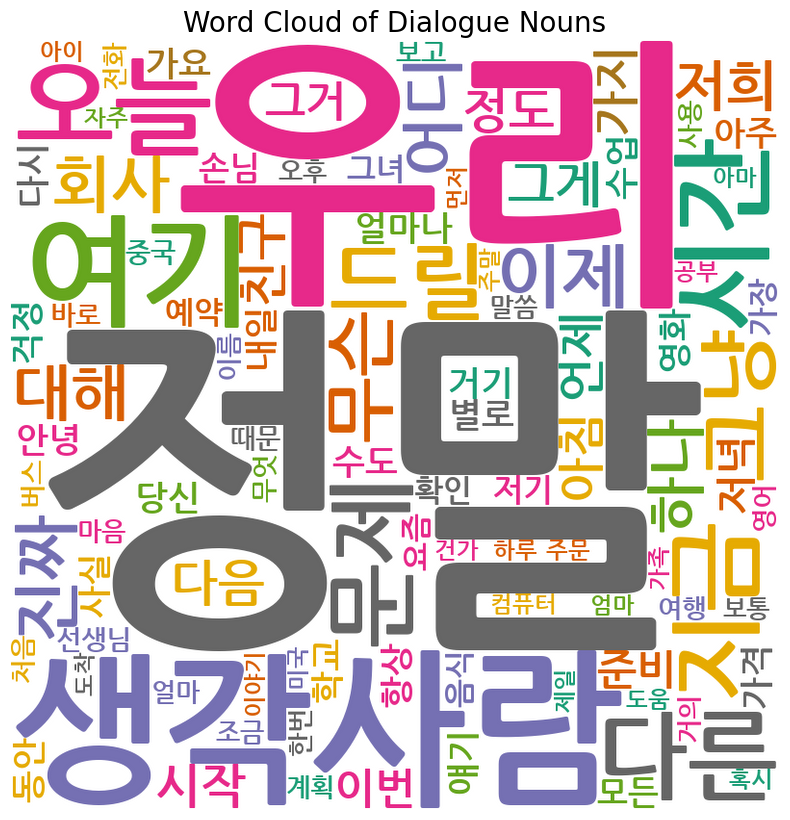

In [5]:
# 형태소 분석기 준비
okt = Okt()

# 명사만 추출하는 함수 정의
def get_nouns(text):
    return [n for n in okt.nouns(text) if len(n) > 1]

# train 전체 dialogue에서 명사 추출
dialogue_nouns = train["dialogue"].apply(get_nouns).explode().dropna()
noun_counts = Counter(dialogue_nouns)

# 상위 100개 명사 추출
most_common_nouns = noun_counts.most_common(100)

# 워드클라우드 생성
wc = WordCloud(
    font_path="/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf",
    background_color="white",
    colormap="Dark2",
    width=800,
    height=800
).generate_from_frequencies(dict(most_common_nouns))

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='lanczos')
plt.axis("off")
plt.title("Word Cloud of Dialogue Nouns", fontsize=20)
plt.show()

In [7]:
# TF-IDF 기반 주요 단어 추출

# TF-IDF 벡터라이저 정의
tfidf = TfidfVectorizer(
    tokenizer=get_nouns,
    min_df=5,
    max_df=0.9,
    max_features=100,
)

# 전체 dialogue에서 tf-idf 계산
tfidf_matrix = tfidf.fit_transform(train["dialogue"])
feature_names = tfidf.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1  # 전체 문서에서의 중요도 합계

# 결과 정리
tfidf_scores = pd.DataFrame({
    "word": feature_names,
    "score": scores
}).sort_values(by="score", ascending=False)

print(tfidf_scores.head(20))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


   word        score
80   정말  1223.069583
60   여기   824.886916
68   우리   823.125258
39   사람   780.539000
42   생각   732.941828
65   오늘   629.026385
47   시간   554.408750
87   지금   537.605388
24   드릴   502.183176
16   다른   490.314221
32   문제   473.481676
30   무슨   443.644196
13   그냥   442.909906
88   진짜   431.499256
73   이제   427.731396
55   어디   410.863683
92   하나   389.215250
18   다음   366.745078
99   회사   360.154634
77   저희   359.814939


In [8]:
# 10. 중복 데이터 탐지

# 중복된 (dialogue, summary) 쌍 확인
duplicate_dialogue_summary = train.duplicated(subset=["dialogue", "summary"]).sum()

# dialogue만 중복된 경우 (요약이 다름)
duplicate_dialogue_only = train.duplicated(subset=["dialogue"]).sum()

print(f"✅ (dialogue, summary) 완전 중복: {duplicate_dialogue_summary}건")
print(f"✅ dialogue만 중복 (summary 다름): {duplicate_dialogue_only}건")

✅ (dialogue, summary) 완전 중복: 0건
✅ dialogue만 중복 (summary 다름): 0건


In [12]:
# 11. ROUGE 평가 대비 요약 품질 예시 확인

# 요약이 지나치게 짧거나 긴 샘플 추출
train["dialogue_len"] = train["dialogue"].apply(len)
train["summary_len"] = train["summary"].apply(len)
train["length_ratio"] = train["summary_len"] / train["dialogue_len"]

# 길이 차이가 극단적인 샘플 5개 출력
extreme_samples = train[(train["length_ratio"] < 0.05) | (train["length_ratio"] > 0.5)]
for i, row in extreme_samples.iterrows():
    print(f"\n[Dialogue]\n{row['dialogue']}\n\n[Summary]\n{row['summary']}\n")



[Dialogue]
#Person1#: 그 영화에서 두 주연 배우의 연기 어떻게 생각해? 
#Person2#: 주인공 연기가 여주인공보다 좀 부족하다고 생각해. 너는 어때? 
#Person1#: 음, 나는 그렇게 생각 안 해. 주인공이 더 믿을 만하다고 봐.

[Summary]
#Person2#는 주인공 연기가 여주인공보다 부족하다고 생각하지만, #Person1#은 주인공이 더 믿음이 간다고 본다.


[Dialogue]
#Person1#: 아기가 밤에 자주 깰 것 같아요.
#Person2#: 엄마가 이사 오신 이후로 아기가 밤에 더 오래 자서 좋아요. 그런데 엄마로서 생각이 많아서 제가 잠이 잘 안 와요.

[Summary]
#Person2#는 어머니가 이사 오신 후 아기가 밤에 더 잘 자게 되었지만, 본인은 생각이 많아 잠을 잘 못 잔다고 말했습니다.


[Dialogue]
#Person1#: 노란색보다 이 흰 치마가 너한테 더 잘 어울리는 것 같아.
#Person2#: 고마워. 나도 흰색이 더 마음에 들어. 그런데 얼마에 파실 거예요?
#Person1#: 100달러인데, 30% 할인해줄게.

[Summary]
#Person1#과 #Person2#는 흰색 치마가 더 잘 어울린다고 생각하며, #Person1#이 할인된 가격을 제시합니다.


[Dialogue]
#Person1#: 저기요, 낚시할 만한 곳 좀 알려주실 수 있나요?
#Person2#: 저도 낚시 좋아해요. 저는 주로 호수 근처에서 낚시해요.
#Person1#: 오늘 낚시 가고 싶은데, 집에 낚싯대랑 줄을 두고 왔네요.
#Person2#: 안타깝네요.

[Summary]
#Person2#는 #Person1#에게 호수 근처에서 주로 낚시를 한다고 말하고, #Person1#는 낚싯대와 줄을 집에 두고 와서 낚시를 가기 어려움을 토로합니다.


[Dialogue]
#Person1#: 미리 예매한 게 참 잘한 것 같아! 
#Person2#: 아, 정말 그렇게 생각해? 
#Person1#: 물론이지, 안